# Exercise 2 : The Binary star 94 Aqr MATISSE observation


In this second exercise we will use VLTI/MATISSE data obtained on the binary star 94 Aqr. 

The dataset consist in two files:

- 2018-07-17T085626\_94Aqr\_Part1.fits
- 2018-07-17T085626\_94Aqr\_Part2.fits


Actually, these files represent a single MATISSE observation with the A0B2C1D0 quadruplet. 

The measurement was split in two files for the purpose of this practice session :
- **Part1** contains only the data from the B2-C1-D0 triplet (3 baselines and 1 closure phase)
- **Part2** contains the other baselines (A0-B2, A0-C1, and A0-D0)

### Let's start by some imports and setting the path to the 94 Aqr MATISSE observation.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import oimodeler as oim
from matplotlib.colors import LogNorm
from pprint import pprint as print
import astropy.units as u


path = Path(os.getcwd()).parents[2] # oimodeler package root path

dir_data = Path(path / "data" / "RealData" / "MATISSE" / "94 Aqr")

### In the first part of this session we will focus on the first fits file

In [7]:
filename= dir_data / "2018-07-17T085626_94Aqr_Part1.fits"

## Checking and plotting the data

### Let's have a look at the data.

**oimodeler** offer different functions to plot uv-plan coverage and the data. 

The package comes with the **oimAxes** class that is a subclass of the standard **matplotlib.pytplot.Axes** class (the base class for all matplotlib plots). 

To use it, you simply need to specify it as a projection (actually this calls the subclass) when creating an axe or axes. 

We can then call the  **uvplot** method to plot the uv-plan coverage 

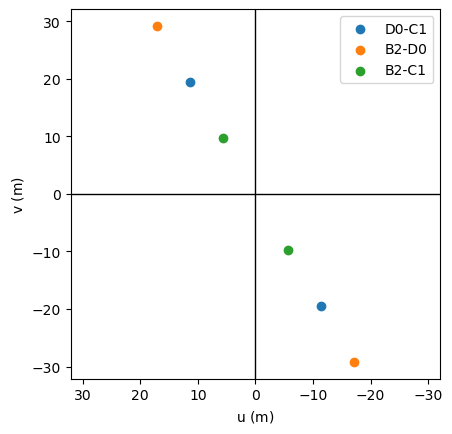

In [10]:
figuv = plt.figure()
axuv = plt.subplot(projection='oimAxes')
axuv.uvplot(filename,color="byBaseline")

#### **Question: What are the orientations of the baselines in the B2-C1-D0?**


ANSWER HERE

### The data can be plotted using the **oiplot** function. 

For instance, if we want to plot the squared-visibility and closure phase as a function of the spatial frequency (in cycle/mas):

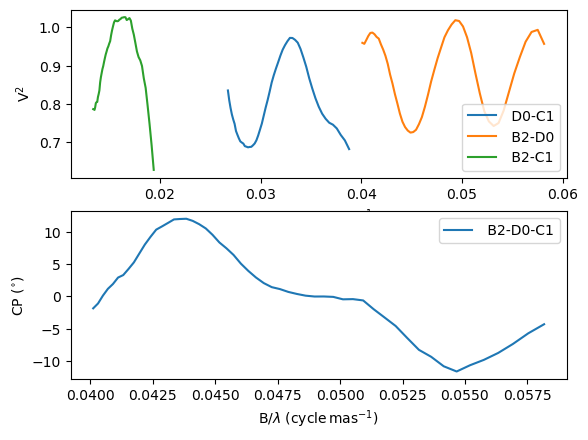

In [15]:
figdata, axdata = plt.subplots(2,1, subplot_kw=dict(projection='oimAxes'))
axdata[0].oiplot(filename, "SPAFREQ", "VIS2DATA", color="byBaseline",xunit="cycle/mas")
axdata[0].legend()
axdata[1].oiplot(filename, "SPAFREQ", "T3PHI",color="byBaseline",xunit="cycle/mas")
axdata[1].legend()

> **Note**: To use the **oimAxes** in a multi-plot created by **matplotlib.pyplot.subplots** method, one need to set the projection using the *subplot\_kw* keyword when creating the axes.

#### **Question: determine the projected separation and flux ratio of the components from the visibility plot**
We can use the knowledge acquired from the previous practice sessions 

ANSWER HERE

### Let's build a simple binary model using two point sources:

**Replace the XXX by some proper values depending on the projected separation and flux ratio you estimated**

In [21]:
pt1 = oim.oimPt()
pt2 = oim.oimPt()
m_bin = oim.oimModel(pt1,pt2)

pt1.params["f"] = oim.oimParamNorm(pt2.params["f"])
pt2.params["x"].set(min= -200, max= 200, free = True)
pt2.params["y"].set(min= -200, max= 200, free = True)
pt2.params["f"].set(min=0, max= 0.2)

> **Note:** The call to **oimParamNorm** allows to normalise the total flux of our model to 1 (in practice it replaces **pt1** flux parameter by the value one minus the **pt2** flux parameter).

By default the positions **x** and **y** of all components are fixed and set to 0, so we need to set them free for the the companion (pt2) and set a parameter space (min and max) larger than the projected separation determined in the previous section.

### Run a mcmc fitter 
We can use 2000 steps and 20 walkers.

In [25]:
fit=oim.oimFitterEmcee(filename, m_bin,nwalkers=20,dataTypes=["VIS2DATA","T3PHI"])
fit.prepare()
fit.run(nsteps=2000,progress=True)

100%|██████████| 2000/2000 [00:03<00:00, 588.10it/s]


{'nsteps': 2000, 'progress': True}

### Print and plot the mcmc-run results

c2_Pt_x = -8.32855 ± 91.56182 mas
c2_Pt_y = -136.37063 ± 53.51035 mas
c2_Pt_f = 0.08332 ± 0.00070 
chi2r = 0.88574


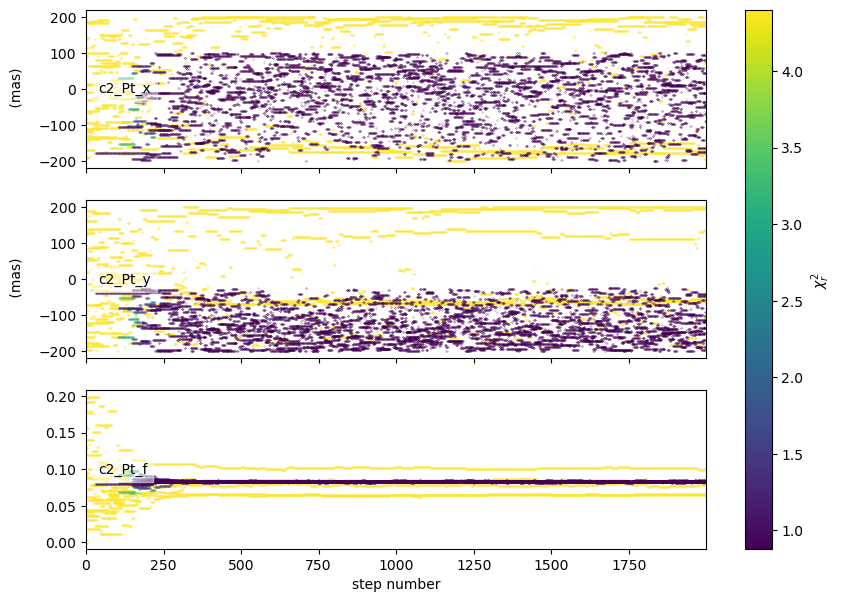

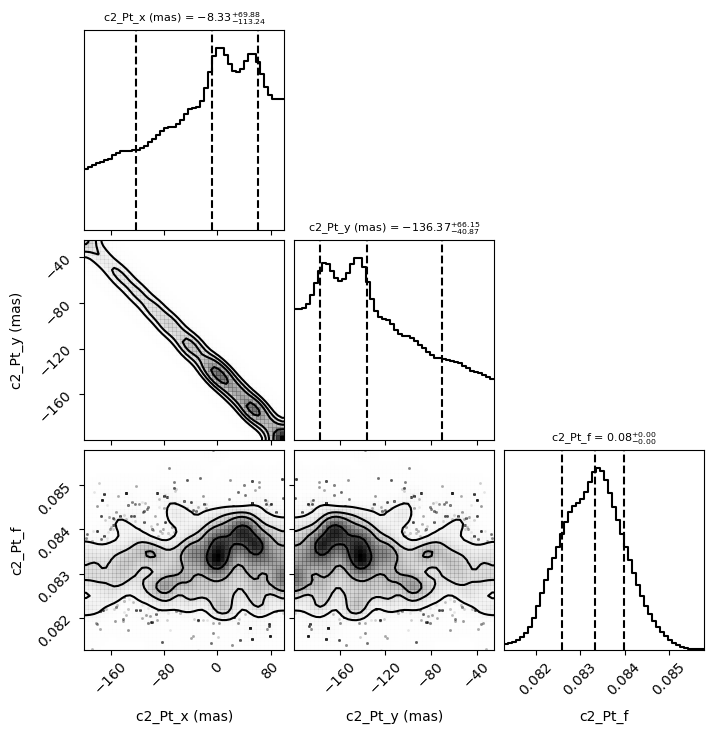

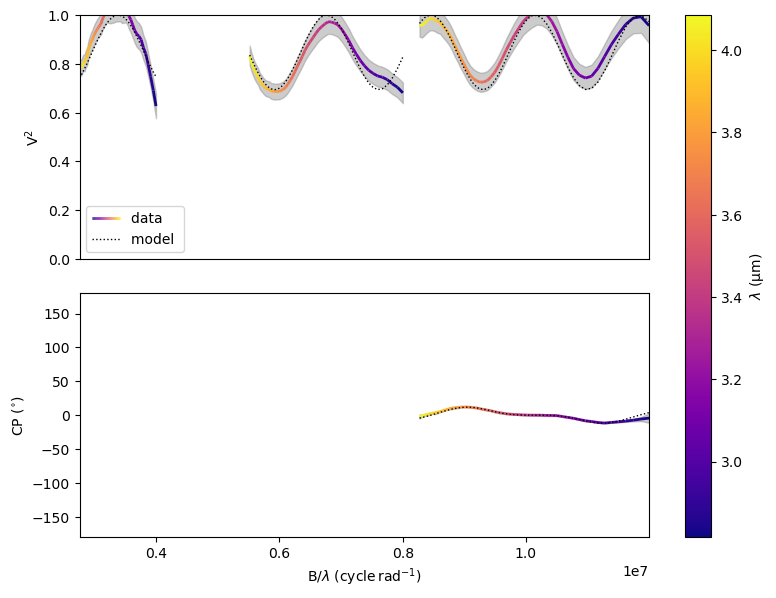

In [28]:
fit.printResults(mode='median', discard=1000)
figWalker,axWalker = fit.walkersPlot(chi2limfact=5)
figCorner,axCorner = fit.cornerPlot(discard=1000, chi2limfact=5)
figSim,axSim = fit.simulator.plot(["VIS2DATA","T3PHI"])

#### **Question: Which parameters are well constrained and which are not?**

#### **Question: Can you explain why?**


### Exploring the parameters space with 2D $\chi^2_r$ Map

To better understand the problem we can build a 2D dimensional $\chi^2_r$ map to explore the binary separation. 
We will fix the flux of the companion, to the value determined in the MCMC fit (or directly on the visibility plot) to have only 2 free parameter in our grid exploration.

**Replace the XXX in the code below with the proper value**

100%|██████████| 6561/6561 [00:01<00:00, 5715.64it/s]


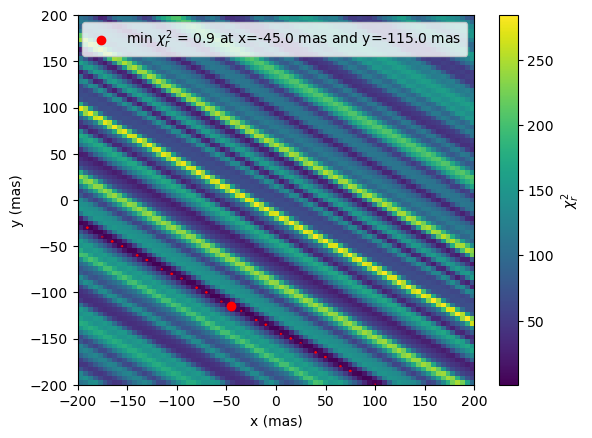

In [33]:
pt2.params["f"].value= 0.083
grid = oim.oimFitterRegularGrid(filename,m_bin,dataTypes=["VIS2DATA","T3PHI"])
grid.prepare(steps=[5,5], min=[-200,-200], max=[200,200],params=[pt2.params["x"],pt2.params["y"]])
grid.run()
fig,ax = grid.plotMap(plotContour=True)

#### **Question: How are x and y correlated?**

#### **Question: Does this correspond to what have been found with the mcmc fitter?**

### Let's try to determine the equation linking the separation x and y.

As already stated, **oimodeler** is wrapping a sampler from the emcee library. After a mcmc run you can access the sampler via the fit.sampler variable and used it directly as in emcee. 

For instance if we want to retrieve the position of the emcee sampler through the run we can use the [get_chain](https://emcee.readthedocs.io/en/stable/user/sampler/) method. For the log of probability function (implement as -0.5 $\chi^2$ in **oimodeler**, we can use the **get_log_prob** method.  

The following code allows to retrieve the position of the x and y parameters and the $\chi^2$ and for all walkers (flat=True merged all walkers together) discarding the 1000 first steps. Finally As some walker haven't converged to the "good" position we also select only the ones with a $\chi^2$ of less than 5 times the minimum one using the numpy where function.

In [38]:
x =    fit.sampler.get_chain(flat=True, discard=1000)[:,0] # walkers positions of x parameter
y =    fit.sampler.get_chain(flat=True, discard=1000)[:,1] # walkers positions of y parameter
chi2 = -2*fit.sampler.get_log_prob(flat=True, discard=1000) # chi2 of the sampler thorugh the run

#We only select the points where the chi2 is less than 5 times the minimum
idx = np.where(chi2<chi2.min()*5)[0]
x1 = x[idx]
y1 = y[idx]

### We can now perform a polynomial fit with numpy **polyfit** function to determine the coefficient. 

In [41]:
p=np.polyfit(x1,y1,1)
xp = np.linspace(-200,100)
yp = np.poly1d(p)(xp)

### Let's overplot the result on our $\chi^2_r$ map.

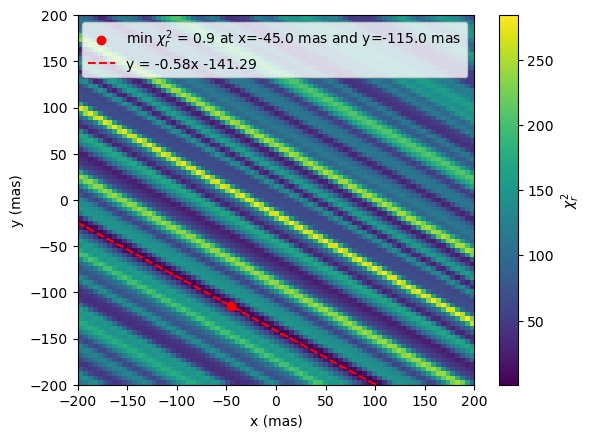

In [44]:
fig,ax = grid.plotMap(plotContour=True)
ax.plot(xp,yp,color="red",ls="--",label=f"y = {p[0]:.2f}x {p[1]:.2f}")
ax.legend()

These coefficients are linked to the baselines position angle (in our case about 30.2$^o$) and projected separation (the one measured from the sinusoidal modulation.

#### **Bonus Question: Can you find the relation between the ployfit coefficients and the PA and projected separation?**
**Don't spend to much time it is just a bonus question!**

$$ y =  \frac{1}{tan(PA)} x - \frac{sep_p}{cos(PA)}$$ 

## Part 2: Using the full set of MATISSE data

### Now we will load the complete MATISSE observation (separated in the two files). 


In [50]:
filename= list(dir_data.glob("*.fits"))
print(filename)

[WindowsPath('C:/Travail/GitHub/oimodeler/data/RealData/MATISSE/94 Aqr/2018-07-17T085626_94Aqr_Part1.fits'),
 WindowsPath('C:/Travail/GitHub/oimodeler/data/RealData/MATISSE/94 Aqr/2018-07-17T085626_94Aqr_Part2.fits')]


### Let's have a look at the uv-plan, square visiblity and closure phase

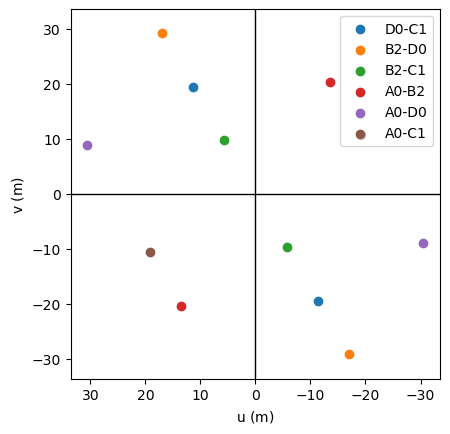

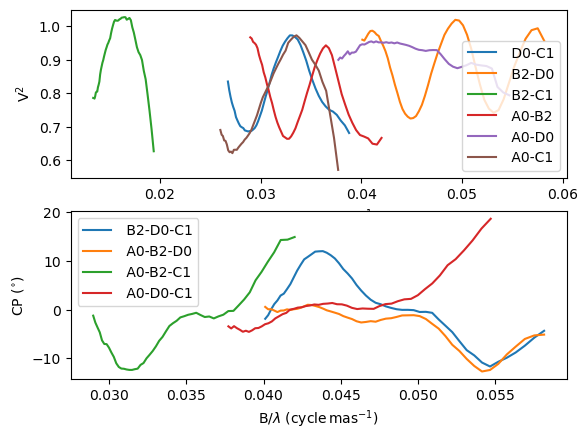

In [53]:
figuv = plt.figure()
axuv = plt.subplot(projection='oimAxes')
axuv.uvplot(filename,color="byBaseline")


figdata, axdata = plt.subplots(2,1, subplot_kw=dict(projection='oimAxes'))
axdata[0].oiplot(filename, "SPAFREQ", "VIS2DATA", color="byBaseline",xunit="cycle/mas")
axdata[0].legend()
axdata[1].oiplot(filename, "SPAFREQ", "T3PHI", color="byBaseline",xunit="cycle/mas")
axdata[1].legend()

#### **Question: Which baseline appears to be almost perpendicular to the binary separation?**

### Creating a 2D $\chi^2_r$ grid 
The grid explores the position (x,y) parameters.
The flux is fixed to to its previously determined best value

**Replace the XXX by the fitted value of the flux and the x and y parameter space**

In [57]:
pt2.params["f"].value = 0.083
grid1 = oim.oimFitterRegularGrid(filename,m_bin,dataTypes=["VIS2DATA","T3PHI"])
grid1.prepare(steps=[2,2],min=[-200,-200],max=[200,200],params=[pt2.params["x"],pt2.params["y"]])
grid1.run()

100%|██████████| 40401/40401 [00:12<00:00, 3158.81it/s]


{}

### Plotting the $\chi^2_r$ map

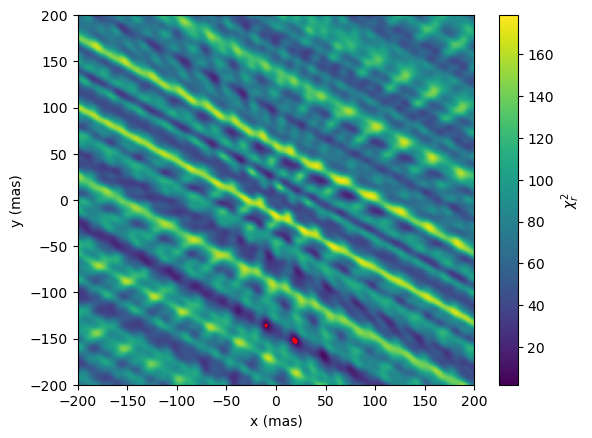

In [59]:
fig,ax = grid1.plotMap(plotContour=True,plotMin=False)

#### **Question: How does it differs from the $\chi^2_r$ map created in the previous section?**

#### **Question: Will we able to fully constrain our model (without degeneracy) with such dataset?**

#### **Question: Will the mcmc fitter converge easily to the global minimum? same question for a standard minimization fitter?**

### Let's try to zoom on the global minimum (or minimas)

We crerate a second grid explorer around the minimum with a smaller step (keep more or less same grid size).

**Replace XXX by proper values for the zoomed grid**

In [65]:
grid2=oim.oimFitterRegularGrid(filename,m_bin,dataTypes=["VIS2DATA","T3PHI"])
grid2.prepare(steps=[0.4,0.4],min=[-40,-160],max=[70,-120],params=[pt2.params["x"],pt2.params["y"]])
grid2.run()

100%|██████████| 28152/28152 [00:08<00:00, 3155.01it/s]


{}

### Plotting the zoomed-in $\chi^2_r$ map

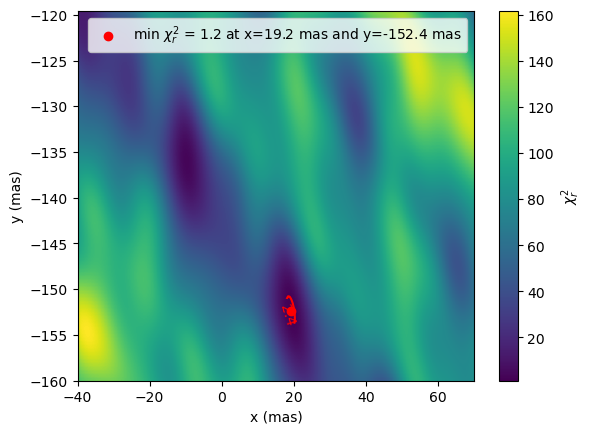

In [68]:
fig,ax=grid2.plotMap(plotContour=True)

#### **Question: What is the ratio between the $\chi^2_r$ of the global minimum and that of the two surrounding local minima?**


### Now let's run a mcmc fitter to finally get the binary separation

In [78]:
pt2.params["x"].set(min= 10, max= 30, free = True)
pt2.params["y"].set(min= -160, max= -145, free = True)
fit=oim.oimFitterEmcee(filename, m_bin,nwalkers=20,dataTypes=["VIS2DATA","T3PHI"])
fit.prepare()
fit.run(nsteps=2000,progress=True)

100%|██████████| 2000/2000 [00:14<00:00, 141.66it/s]


{'nsteps': 2000, 'progress': True}

### And we plot the MCMC-fit results

c2_Pt_x = 19.04855 ± 0.04511 mas
c2_Pt_y = -152.37322 ± 0.06028 mas
c2_Pt_f = 0.08641 ± 0.00050 
chi2r = 1.11550


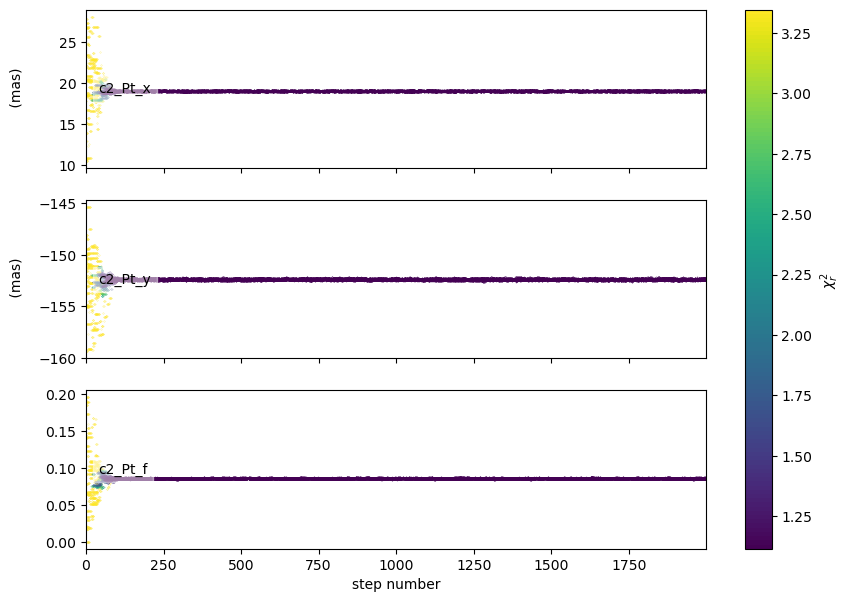

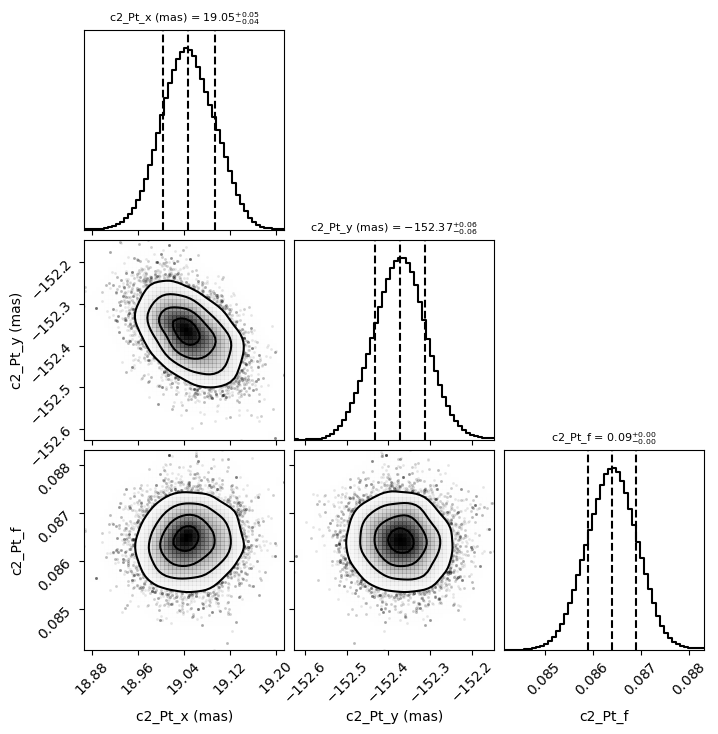

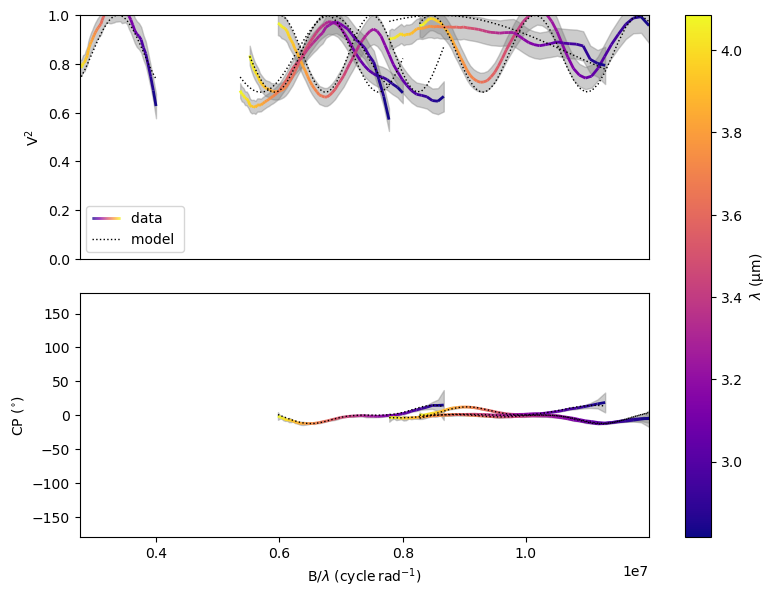

In [80]:
fit.printResults(mode='best', discard=1000,chi2limfact=3)
figWalker,axWalker = fit.walkersPlot(chi2limfact=3)
figCorner,axCorner = fit.cornerPlot(1000,chi2limfact=3)
figSim,axSim = fit.simulator.plot(["VIS2DATA","T3PHI"])

#### **Question: Do you have any idea(s) how to help the walkers to converge faster to the global minimum?**

**One solution is quite obvious and you should find it and implement it by yourself in the cell below**

In [61]:
#  WRITE YOUR CODE HERE 
#  Implement a simple solution to force all walkers to converge to the global minimum

The 2nd method uses two mcmc-samplers. The first one explores the full parameters space with random initial position set by the fit.prepare method.

### Let's prepare and run the first sampler (similar to the one we ran before)

In [86]:
pt2.params["x"].set(min= -200, max=200, free = True)
pt2.params["y"].set(min= -200, max= 200, free = True)

fit=oim.oimFitterEmcee(filename, m_bin,nwalkers=20,dataTypes=["VIS2DATA","T3PHI"])
fit.prepare()
fit.run(nsteps=2000,progress=True)

100%|██████████| 2000/2000 [00:10<00:00, 199.20it/s]


{'nsteps': 2000, 'progress': True}

### We get and plot the results

Some walkers are stucked in local minima

c2_Pt_x = 19.05094 ± 0.04753 mas
c2_Pt_y = -152.36510 ± 0.06742 mas
c2_Pt_f = 0.08639 ± 0.00056 
chi2r = 1.11553


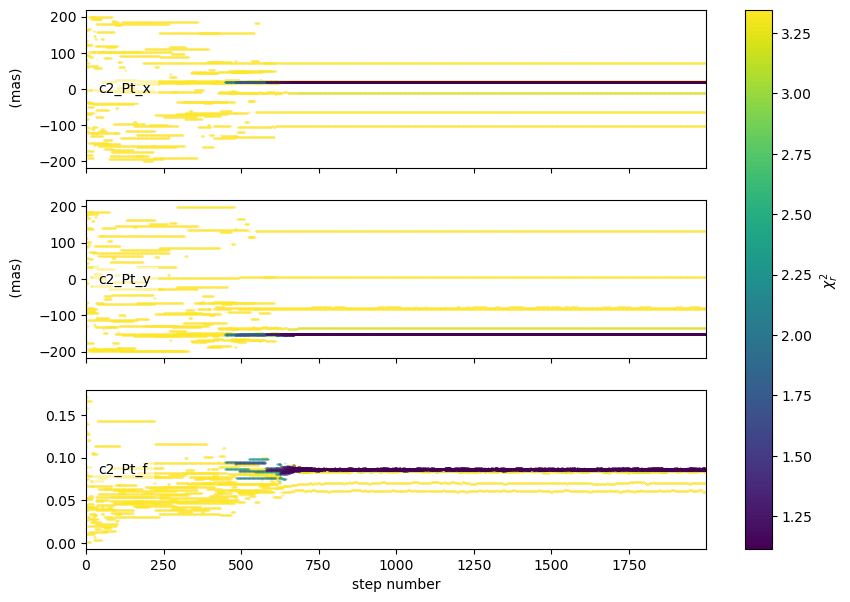

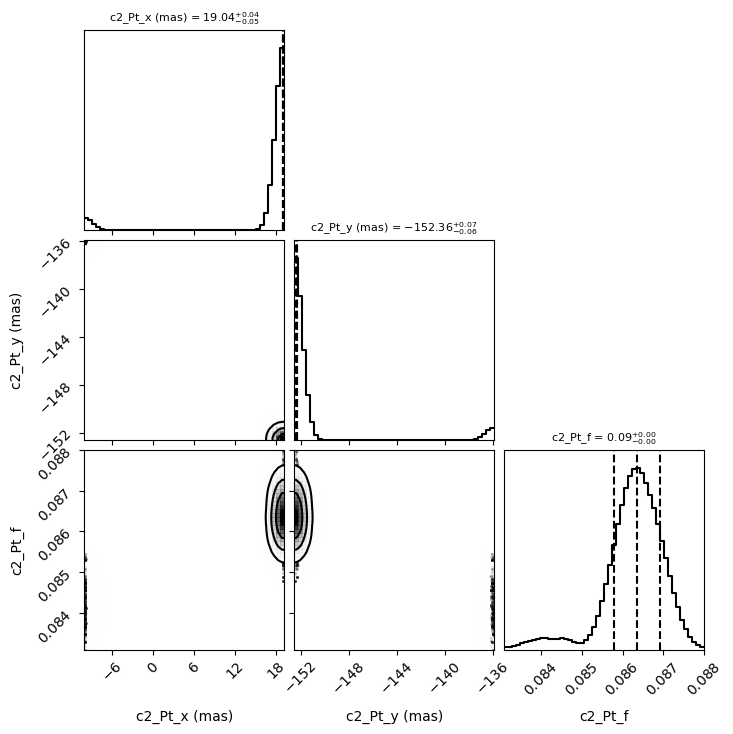

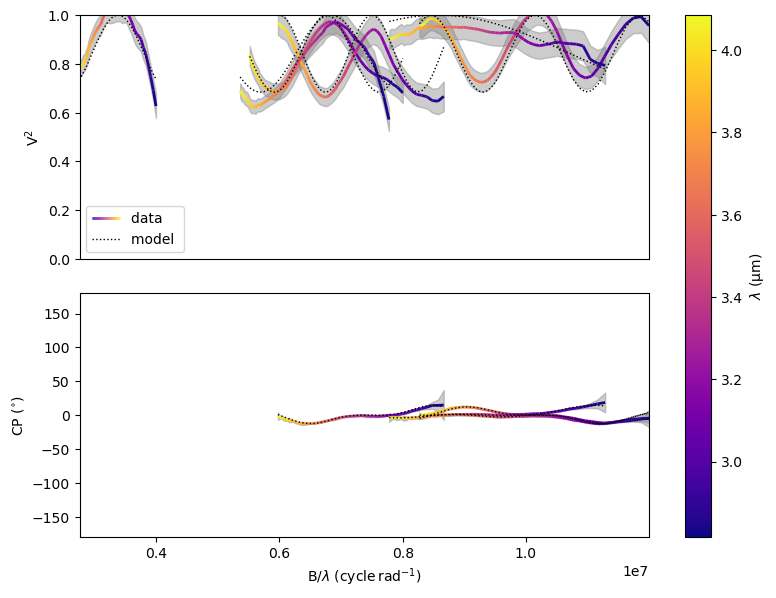

In [88]:
fit.printResults(mode='best', discard=1000,chi2limfact=3)
figWalker,axWalker = fit.walkersPlot(chi2limfact=3)
figCorner,axCorner = fit.cornerPlot(1000,chi2limfact=3)
figSim,axSim = fit.simulator.plot(["VIS2DATA","T3PHI"])

The printResults method set the model to the current values of our best model (discrading 1000 steps and $\chi^2$ values above 3 times the minimum)

### Let's print the model current values

In [91]:
m_bin.getFreeParameters()

{'c2_Pt_x': oimParam at 0x1e05c5a4770 : x=19.050938277031367 ± 0.04753009243282236 mas range=[-200,200] free=True ,
 'c2_Pt_y': oimParam at 0x1e05c30ecc0 : y=-152.3651032708356 ± 0.06741943167638453 mas range=[-200,200] free=True ,
 'c2_Pt_f': oimParam at 0x1e05c30cb60 : f=0.08638667518508922 ± 0.0005647263665050778  range=[0,0.2] free=True }

We see that the x, y and f are set to the best model values with the estimated uncertainties (shown by the $\pm$ sign)

### A second sampler is initialised with the **init="gaussian"** option. 

In that case, the initialisation is performed as a random Gaussian centred on the current model parameters (set to the best ones determined by the first fitter) and with a FWHM of equal to the **err** value of the parameters (also set to the uncertainties determined by the first fit)

In [94]:
fit2 = oim.oimFitterEmcee(filename, m_bin,nwalkers=20,dataTypes=["VIS2DATA","T3PHI"])
fit2.prepare(init="gaussian")

{}

### We can check to initial values of our parameters

In [97]:
print(fit2.initialParams)

array([[ 1.90164229e+01, -1.52349443e+02,  8.65124682e-02],
       [ 1.90798972e+01, -1.52390443e+02,  8.72626608e-02],
       [ 1.90887787e+01, -1.52336102e+02,  8.59862330e-02],
       [ 1.90574149e+01, -1.52324255e+02,  8.67994147e-02],
       [ 1.89687210e+01, -1.52422806e+02,  8.67176212e-02],
       [ 1.90588446e+01, -1.52281721e+02,  8.63808219e-02],
       [ 1.90808661e+01, -1.52217717e+02,  8.60560766e-02],
       [ 1.90776307e+01, -1.52391369e+02,  8.62010734e-02],
       [ 1.89933686e+01, -1.52380367e+02,  8.57898206e-02],
       [ 1.89906238e+01, -1.52427300e+02,  8.61433345e-02],
       [ 1.90166501e+01, -1.52469229e+02,  8.77593261e-02],
       [ 1.90598993e+01, -1.52313264e+02,  8.66518544e-02],
       [ 1.91109159e+01, -1.52386416e+02,  8.55635661e-02],
       [ 1.89885562e+01, -1.52421619e+02,  8.74691711e-02],
       [ 1.91342901e+01, -1.52401184e+02,  8.69963027e-02],
       [ 1.90641233e+01, -1.52270056e+02,  8.65040572e-02],
       [ 1.89995602e+01, -1.52392046e+02

### We run the second mcmc-sampler

In [100]:
fit2.run(nsteps=500,progress=True)

100%|██████████| 500/500 [00:03<00:00, 130.53it/s]


{'nsteps': 500, 'progress': True}

### And finally get results

c2_Pt_x = 19.04687 ± 0.04495 mas
c2_Pt_y = -152.36740 ± 0.05983 mas
c2_Pt_f = 0.08646 ± 0.00050 
chi2r = 1.11550


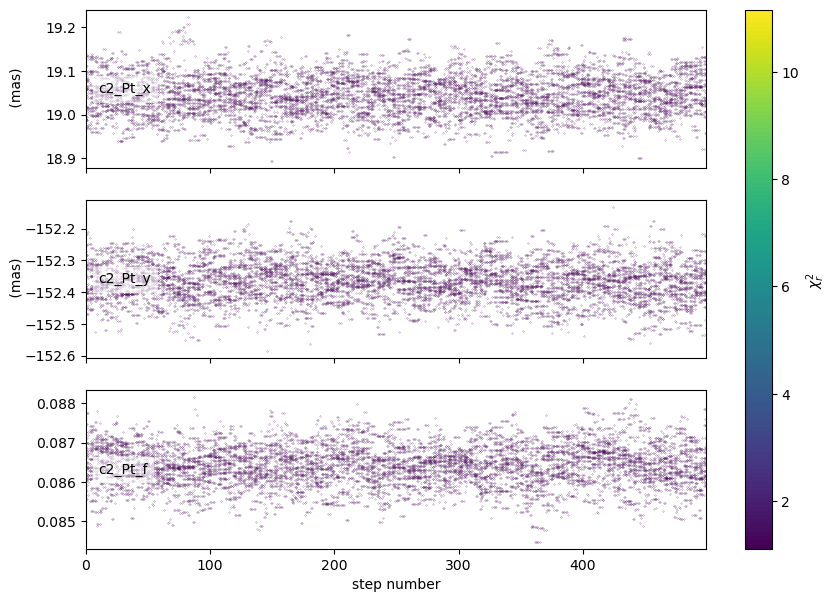

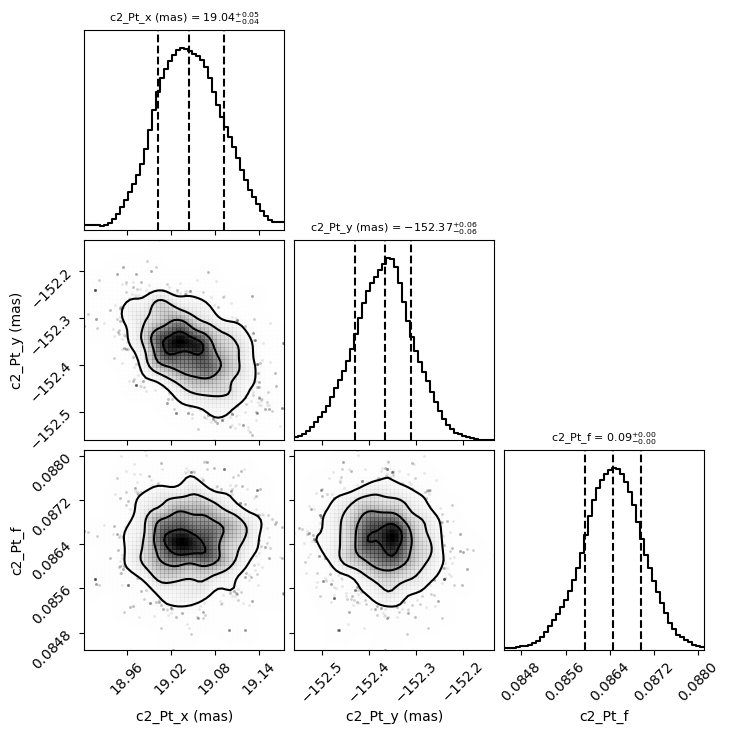

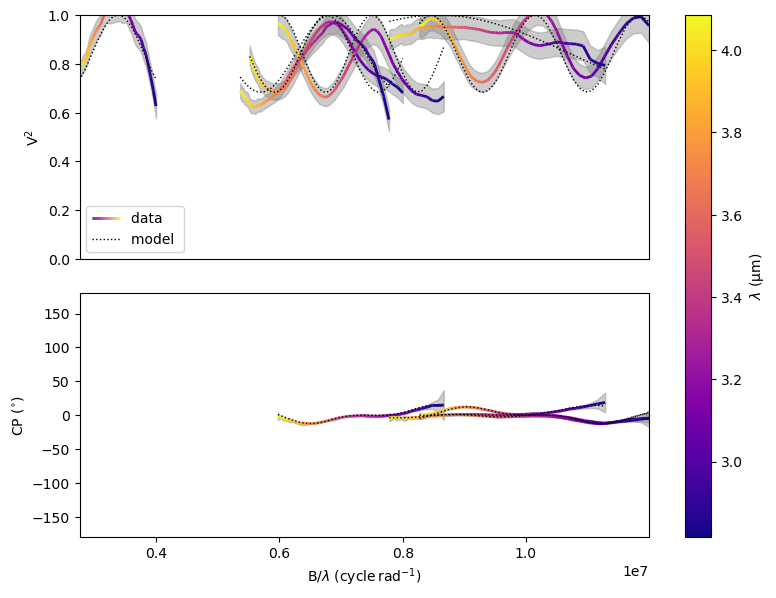

In [102]:
fit2.printResults(mode='best', discard=300,chi2limfact=3)
figWalker,axWalker = fit2.walkersPlot(chi2limfact=10)
figCorner,axCorner = fit2.cornerPlot(300,chi2limfact=3)
figSim,axSim = fit2.simulator.plot(["VIS2DATA","T3PHI"])